# **Homework 2: Model-free RL**
#### **Created by 65340500058 Anuwit Intet**

## **Learning Objectives:**

- Understand how a reinforcement learning agent learns (i.e., evaluates and improves its policy) in an environment where the true dynamic model is unknown.

- Gain insight into different reinforcement learning algorithms, including Monte Carlo methods, the SARSA algorithm, Q-learning, and Double Q-learning. Analyze their strengths and weaknesses.

- Explore approaches to implementing reinforcement learning in real-world scenarios where the state and action spaces are continuous.

In [ ]:
import torch
import numpy as np
from RL_Algorithm.RL_base import ControlType

## <font color="pink">**Part 1: Setting up Cart-Pole Agent**</font>

For the first part of this homework, you will implement a Cart-Pole agent from scratch, i.e., you must implement the constructor and core functions of the RL Base Class, as well as the algorithms in the Algorithm folder. The core components should include, but are not limited to:



1. RL Base class
- This class should include:

    - Constructor (__init__) to initialize the following parameters:

        - Control type: Enumeration of RL algorithms used for decision-making (i.e. Monte Carlo, Temporal Difference, Q-learning, or Double Q-learning).

        - Number of actions: The total number of discrete actions available to the agent.

        - Action range: The minimum and maximum values defining the range of possible actions.

        - Discretize state weight: Weighting factor applied when discretizing the state space for learning.

        - Learning rate: Determines how quickly the model updates based on new information.

        - Initial epsilon: The starting probability of taking a random action in an ε-greedy policy.

        - Epsilon decay rate: The rate at which epsilon decreases over time to favor exploitation over exploration.

        - Final epsilon: The lowest value epsilon can reach, ensuring some level of exploration remains.

        - Discount factor: A coefficient (γ) that determines the importance of future rewards in decision-making.

    - Core Functions

        - get_discretize_action(): Returns a discrete action based on the current policy.

        - mapping_action(): Converts a discrete action back into a continuous action within the defined action range.

        - discretize_state(): Discretizes and scales the state based on observation weights.

        - decay_epsilon(): Decreases epsilon over time and returns the updated value.

Additional details about these functions are provided in the class file.

- Note: The RL Base Class also include two additional functions:

    - save_q_value() which save model function from Q(s,a) as defaultdict.

    - load_q_value() which load model function from Q(s,a) as defaultdict.

You may also implement additional functions for further analysis.

### <font color="yellow">**discretize_state()**</font>

In [ ]:
def discretize_state(self, obs: dict): # write in own task
    """ 
    Discretize the observation state.

    Args:
        obs (dict): Observation dictionary containing policy states.

    Returns:
        Tuple[pose_cart:int, pose_pole:int, vel_cart:int, vel_pole:int]: Discretized state.
    """

    # ========= put your code here ==========
    
    # define number of value
    pose_cart_bin = self.discretize_state_weight[0]
    pose_pole_bin = self.discretize_state_weight[1]
    vel_cart_bin = self.discretize_state_weight[2]
    vel_pole_bin = self.discretize_state_weight[3]

    # Clipping value
    pose_cart_bound = 3
    pose_pole_bound = float(np.deg2rad(24.0))
    vel_cart_bound = 10
    vel_pole_bound = 10
    
    # get observation term from continuos space
    pose_cart_raw, pose_pole_raw , vel_cart_raw , vel_pole_raw = obs['policy'][0, 0] , obs['policy'][0, 1] , obs['policy'][0, 2] , obs['policy'][0, 3]

    print(f"Raw Values: pose_cart={pose_cart_raw}, pose_pole={pose_pole_raw}, vel_cart={vel_cart_raw}, vel_pole={vel_pole_raw}")

    pose_cart_clip = torch.clip(pose_cart_raw , -pose_cart_bound ,pose_cart_bound)
    pose_pole_clip = torch.clip(pose_pole_raw , -pose_pole_bound ,pose_pole_bound)
    vel_cart_clip = torch.clip(vel_cart_raw , -vel_cart_bound ,vel_cart_bound)
    vel_pole_clip = torch.clip(vel_pole_raw , -vel_pole_bound ,vel_pole_bound)

    print(f"Clipped Values: pose_cart={pose_cart_clip}, pose_pole={pose_pole_clip}, vel_cart={vel_cart_clip}, vel_pole={vel_pole_clip}")

    device = pose_cart_clip.device

    # create grid for discretization
    pose_cart_grid = torch.linspace(-pose_cart_bound , pose_cart_bound , pose_cart_bin , device=device)
    pose_pole_grid = torch.linspace(-pose_pole_bound , pose_pole_bound , pose_pole_bin , device=device)
    vel_cart_grid = torch.linspace(-vel_cart_bound , vel_cart_bound , vel_cart_bin , device=device)
    vel_pole_grid = torch.linspace(-vel_pole_bound , vel_pole_bound , vel_pole_bin , device=device)

    print(f"Pose Cart Grid: {pose_cart_grid}")
    print(f"Pose Pole Grid: {pose_pole_grid}")
    print(f"Vel Cart Grid: {vel_cart_grid}")
    print(f"Vel Pole Grid: {vel_pole_grid}")
    
    # Discretization
    pose_cart_dig = torch.bucketize(pose_cart_clip,pose_cart_grid)
    pose_pole_dig = torch.bucketize(pose_pole_clip,pose_pole_grid)
    vel_cart_dig = torch.bucketize(vel_cart_clip,vel_cart_grid)
    vel_pose_dig = torch.bucketize(vel_pole_clip,vel_pole_grid)

    print(f"Discretized Values: pose_cart={pose_cart_dig}, pose_pole={pose_pole_dig}, vel_cart={vel_cart_dig}, vel_pole={vel_pole_dig}")

    return (int(pose_cart_dig), int(pose_pole_dig), int(vel_cart_dig),  int(vel_pose_dig))

    # ======================================#

For example, let's say the code works like this:
- pose_cart_raw=2.5, pose_pole_raw=0.2617993950843811, vel_cart_raw=5.0, vel_pole_raw=-7.0

- self.discretize_state_weight = [10, 10, 10, 10]

==========================================================================================================================

`torch.clip` is the function that clips value to the proper range.

```python
Ex. 
Clipped Values: pose_cart=2.5, pose_pole=0.2617993950843811, vel_cart=5.0, vel_pole=-7.0
```

The value is not correct because it is within the specified range.

==========================================================================================================================

`torch.linspace` Create a break point for discretization by: torch.linspace(start, end, steps, device=device) → Create a range of values ​​from start to end, divided into a number of steps.

```python
Ex.
Pose Cart Grid: tensor([-3.0000, -2.3333, -1.6667, -1.0000, -0.3333,  0.3333,  1.0000,  1.6667,  2.3333,  3.0000])
Pose Pole Grid: tensor([-0.4189, -0.3255, -0.2321, -0.1387, -0.0454,  0.0480,  0.1414,  0.2348,  0.3282,  0.4216])
Vel Cart Grid: tensor([-10.0000,  -7.7778,  -5.5556,  -3.3333,  -1.1111,   1.1111,   3.3333,   5.5556,   7.7778,  10.0000])
Vel Pole Grid: tensor([-10.0000,  -7.7778,  -5.5556,  -3.3333,  -1.1111,   1.1111,   3.3333,   5.5556,   7.7778,  10.0000])
```

Each variable is divided into 10 ranges (bin=10).

==========================================================================================================================

`torch.bucketize` is used to specify which bin range x falls in, which will give the index of that bin.

```python
Ex. 
Discretized Values: pose_cart=9, pose_pole=8, vel_cart=7, vel_pole=2
```

pose_cart=9 → is in bin 9, pose_pole=8 → is in bin 8, vel_cart=7 → is in bin 7, vel_pole=2 → is in bin 2

### <font color="yellow">**get_discretize_action()**</font>

In [ ]:
def get_discretize_action(self, obs_dis): # -> int (write in own task)
    """
    Select an action using an epsilon-greedy policy.

    Args:
        obs_dis (tuple): Discretized observation.

    Returns:
        int: Chosen discrete action index.
    """
    # ========= put your code here =========#

    if np.random.rand() < self.epsilon:
        # Exploration
        return np.random.randint(self.num_of_action)
    else:
        # Exploitation
        if self.control_type == ControlType.DOUBLE_Q_LEARNING:
            return int(np.argmax(self.qa_values[obs_dis] + self.qb_values[obs_dis]))
        else:
            return int(np.argmax(self.q_values[obs_dis]))
    
    # ======================================#

This function is Action Selection divided into 2 sections:

- Exploration: If the value of np.random.rand() (a random number between 0 and 1) is less than self.epsilon, the function chooses a random action (use np.random.randint(self.num_of_action) to choose a random action from a total of actions).

- Exploitation: If the value of np.random.rand() is not less than self.epsilon, the function selects the action with the highest Q-value from the available actions:

    - If Double Q-Learning is used, the function calculates the Q-value by adding the qa_values ​​and qb_values ​​for the obs_dis state and selecting the action with the highest value using np.argmax.

    - If Double Q-Learning is not used, the function selects the action with the highest Q-value from the q_values ​​for the obs_dis state.

Let's say:
```python
    self.num_of_action = 9 
    self.epsilon = 0.1 
    obs_dis = (2, 4, 1, 1) 
    self.qa_values = {(2, 4, 1, 1): [0.5, 1.0, 0.7, 0.8, 1.5, 0.4, 0.3, 0.9, 1.2]}
    self.qb_values = {(2, 4, 1, 1): [0.4, 1.1, 0.6, 0.7, 1.4, 0.3, 0.5, 0.8, 1.3]}
    self.q_values = {(2, 4, 1, 1): [0.6, 1.0, 0.8, 0.9, 1.6, 0.5, 0.4, 1.1, 1.4]}
```

- Exploration action selection: If np.random.rand() is less than self.epsilon (0.1), the function selects a random action, such as action = np.random.randint(9) (i.e. selects the action at index 2).

- Exploitation action selection: If np.random.rand() is greater than self.epsilon (0.1), the function selects the action with the highest value from the Q-values:

    - In case of Double Q-Learning: Compute the sum of qa_values ​​and qb_values ​​for the state (2, 4, 1, 1) and select the highest value

    - In case of not using Double Q-Learning: Select the action with the highest Q-value from q_values

### <font color="yellow">**mapping_action()**</font>

In [ ]:
def mapping_action(self, action):
    """
    Maps a discrete action in range [0, n] to a continuous value in [action_min, action_max].

    Args:
        action (int): Discrete action in range [0, n]
    
    Returns:
        torch.Tensor: Scaled action tensor.
    """

    # Linear scaling to map discrete action to continuous range
    action_cont = self.action_range[0] + (action / (self.num_of_action - 1)) * (self.action_range[1] - self.action_range[0])

    return torch.tensor(action_cont, dtype=torch.float32)


- Converts action values ​​in the range [0, n] to continuous values ​​in the range [action_min, action_max] using linear scaling.

    - action_range[0]: Minimum value of the range

    - action_range[1]: Maximum value of the range

    - The division (self.num_of_action - 1) is used to convert all actions in the range 0 to n to fit within the continuous range.

- Suppose self.action_range = [-12.0, 12.0] and self.num_of_action = 9:

    - if action = 0 (first action): action_cont = -12.0 + (0 / 8) * (12.0 - (-12.0)) = -12.0

    - if action = 4 (middle action): action_cont = -12.0 + (4 / 8) * (12.0 - (-12.0)) = 0.0

    - if action = 8 (last action): action_cont = -12.0 + (8 / 8) * (12.0 - (-12.0)) = 12.0

### <font color="yellow">**decay_epsilon()**</font>

In [ ]:
def decay_epsilon(self): # write in own task
    """
    Decay epsilon value to reduce exploration over time.
    """
    self.epsilon = max(self.final_epsilon, self.epsilon * self.epsilon_decay)

- Reduce epsilon gradually in each learning cycle by multiplying self.epsilon by self.epsilon_decay , we get an exponential decay curve

- Prevent epsilon from falling below a certain minimum value (self.final_epsilon) by using max(self.final_epsilon, self.epsilon * self.epsilon_decay)

- Example self.epsilon_decay = 0.996

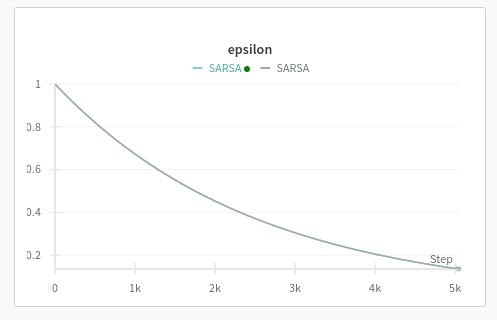

2. Algorithm folder

- This folder should include:

    - Monte Carlo class

    - SARSA class

    - Q-Learning Class

    - Double Q-Learning Class

- Each class should inherit from the RL Base class and include:

    - A constructor which initializes the same variables as the class it inherits from.

    - Superclass Initialization (super().__init__()).

    - An update() function that updates the agent’s learnable parameters and advances the training step.

### <font color="yellow">**Monte Carlo class**</font>

Monte Carlo Control uses environmental exploration and calculates the expected value of each `(s, a)` using the returns from the simulation (Episode-based Learning). This process is done:

**1. Play the Episode**
Compile the sequence of $(s_t, a_t, r_t, s_{t+1})$ until it is complete.

**2. Back to calculate the return**
Use the formula Return (G) to accumulate backward:

$$
G_t = r_t + \gamma G_{t+1}
$$

- $G_t$ is the accumulated return from timestep \( t \) onwards
- $\gamma$ (discount factor) is used to reduce the future return

**3. First-Visit MC**
Only when the state-action `(s, a)` is first encountered in that episode:

Adjust the Q-value according to the formula:

$$
Q(s,a) \leftarrow Q(s,a) + \alpha (G - Q(s,a))
$$

Where $\alpha$ is the learning rate, which is calculated as:

$$
\alpha = \frac{1}{N(s,a)}
$$

So if $N(s,a)$ is increased, the Q-value will be stabilized.

**4.Policy Improvement**
- **Choose action by greedy policy**:

$$
\pi(s) = \arg\max_a Q(s,a)
$$

In [ ]:
def update(
    self,
    state,  # state of the current time step
    action: int,  # action taken
    reward, # reward received
    next_state,  # state after action is taken  
    done: bool = False,  # indicates end of episode   
):
    """
    Update Q-values using Monte Carlo.

    This method applies the Monte Carlo update rule to improve policy decisions by updating the Q-table.
    """

    state = self.discretize_state(state)  # Convert the state into a discrete representation

    # Store transition in memory for later updates
    self.episode_memory.append((state, action, reward))

    # Perform updates only at the end of the episode
    if done:
        G = 0  # Initialize return (G) to zero
        visited = set()  # Keep track of visited (state, action) pairs

        # Iterate through the episode in reverse order (from the last time step to the first)
        for t in reversed(range(len(self.episode_memory))):
            s_t, a_t, r_t = self.episode_memory[t]  # Get state, action, and reward at timestep t
            G = r_t + self.discount_factor * G  # Compute return G using the Bellman equation

            # First-Visit Monte Carlo: update only if (s_t, a_t) is encountered for the first time
            if (s_t, a_t) not in visited:
                visited.add((s_t, a_t))  # Mark this (s, a) pair as visited

                # Count the number of times this (state, action) pair has been visited
                self.n_values[s_t][a_t] += 1  
                
                # Store the return for this (state, action) pair
                self.returns[(s_t, a_t)].append(G)

                # Compute learning rate (alpha) as the inverse of visit count (1 / N(s, a))
                alpha = 1.0 / self.n_values[s_t][a_t]

                # Monte Carlo Q-value update using incremental averaging
                self.q_values[s_t][a_t] += alpha * (G - self.q_values[s_t][a_t])
        
        # Clear the episode memory after the update to prepare for the next episode
        self.episode_memory = []


### <font color="yellow">**SARSA class**</font>

`SARSA` is an **On-Policy Temporal Difference (TD) Learning** algorithm that uses Reinforcement Learning (RL) to learn an **action-value function** $Q(s,a)$ with the following rule updates:

$$
Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \left[ r_t + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t) \right]
$$

**SARSA Equation Parameters**

- $s_t$ = current state 
- $a_t$ = action taken
- $r_t$ = reward received 
- $s_{t+1}$ = next state
- $a_{t+1}$ = next action chosen according to the current policy
- $\alpha$ = learning rate
- $\gamma$ = discount factor

**Key Properties of SARSA:**
- **On-Policy**: Select the next action $a_{t+1}$ using **the same policy as currently learned** 
- **TD Learning**: Update the value of $Q(s,a)$ online, without waiting for the episode to end.


In [ ]:
def update(
    self,
    state,  # state of the current time step
    action: int,  # action taken
    reward: float,  # reward received
    next_state,  # state after action is taken
    next_action: int  # next action taken
):
    """
    Update Q-values using SARSA.

    This method applies the SARSA update rule to improve policy decisions by updating the Q-table.
    """

    # Convert current and next states into discrete representations
    current_state_discrete = self.discretize_state(state)
    next_state_discrete = self.discretize_state(next_state)

    # Retrieve the Q-value of the current (state, action) pair
    current_q = self.q_values[tuple(current_state_discrete)][action]

    # Retrieve the Q-value of the next (state, action) pair, which is chosen using the same policy
    next_q = self.q_values[tuple(next_state_discrete)][next_action]

    # Compute the target using the SARSA update rule: r + γ * Q(s', a')
    target = reward + self.discount_factor * next_q

    # Update Q-value using learning rate (α) and Temporal Difference (TD) error
    self.q_values[tuple(current_state_discrete)][action] += self.learning_rate * (target - current_q)

### <font color="yellow">**Q-Learning Class**</font>

`Q-Learning` is an **Off-Policy Temporal Difference (TD) Learning** algorithm that uses Reinforcement Learning (RL) to learn an **optimal action-value function** $Q(s,a)$ with the following rule updates:

$$
Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \left[ r_t + \gamma \max_{a} Q(s_{t+1}, a) - Q(s_t, a_t) \right]
$$

**Q-Learning Equation Parameters:**

- $s_t$ = current state
- $a_t$ = action taken
- $r_t$ = reward received
- $s_{t+1}$ = next state
- $\max_{a} Q(s_{t+1}, a)$ = maximum Q-value for the next state across all possible actions)
- $\alpha$ = learning rate
- $\gamma$ = discount factor

**Key Properties of Q-Learning**
- Off-Policy Learning: Uses the greedy action for updates, meaning the update does not depend on the current policy used for exploration. (Lack to explore diversity)

- More Exploitative: Since it always picks the action with the highest future reward, it learns the optimal policy faster than SARSA. (Overestimation)

- Less Stable in Noisy Environments: Since Q-learning always assumes the best action will be taken, it can be more sensitive to approximation errors.



In [ ]:
def update(
    self,
    state,  # state of the current time step
    action: int,  # action taken
    reward: float,  # reward received
    next_state,  # state after action is taken
):
    """
    Update Q-values using Q-Learning.

    This method applies the Q-Learning update rule to improve policy decisions by updating the Q-table.
    """
    state = self.discretize_state(state)
    next_state = self.discretize_state(next_state)

    # print("This is ", state)

    # Get the Q-value for the current state and action
    current_q_value = self.q_values[state][action]

    # Get the maximum Q-value for the next state
    max_future_q = np.max(self.q_values[next_state])

    # Q-learning update rule
    updated_q_value = current_q_value + self.learning_rate * (reward + self.discount_factor * max_future_q - current_q_value)

    # Update Q-value in the Q-table
    self.q_values[state][action] = updated_q_value

### <font color="yellow">**Double Q-Learning Class**</font>

`Double Q-Learning` is an improvement over **Q-Learning** to reduce the **Overestimation Bias** that occurs in the Q-value update in the original algorithm. The problem is that selecting the **best action (argmax)** and **evaluating the value of that action** use the same Q-table, which leads to **Overestimation Bias** in estimating the Q-value.

**How to solve the problem with Double Q-Learning**

Double Q-Learning uses **two Q-tables**: $Q_A$ and $Q_B$ to separate the **action selection** and **Q-value estimation** processes:

$$
Q_A(s_t, a_t) \leftarrow Q_A(s_t, a_t) + \alpha \left[ r_t + \gamma Q_B(s_{t+1}, \arg\max_a Q_A(s_{t+1}, a)) - Q_A(s_t, a_t) \right]
$$

$$
Q_B(s_t, a_t) \leftarrow Q_B(s_t, a_t) + \alpha \left[ r_t + \gamma Q_A(s_{t+1}, \arg\max_a Q_B(s_{t+1}, a)) - Q_B(s_t, a_t) \right]
$$

**How ​​Double Q-Learning Works:**
1. Randomly select the update to use $Q_A$ or $Q_B$ at each step.

2. Select the best action from one Q-table (e.g. $\arg\max_a Q_A(s_{t+1}, a)$)

3. Evaluate the action from another Q-table (e.g. $Q_B(s_{t+1}, \arg\max_a Q_A(s_{t+1}, a))$)

**Key Properties of Double Q-Learning**
- Reduce Overestimation Bias compared with Q-Learning.

- Helps to make learning more stable. 



In [ ]:
def update(
    self,
    #========= put your code here =========#
    state,  # state of the current time step
    action: int,  # action taken
    reward: float,  # reward received
    next_state,  # state after action is taken
):
    """
    Update Q-values using Double Q-Learning.

    This method applies the Double Q-Learning update rule to improve policy decisions by updating the Q-table.
    """

    state = self.discretize_state(state)
    next_state = self.discretize_state(next_state)
    
    if np.random.rand() < 0.5:
        best_action = np.argmax(self.qa_values[next_state])
        self.qa_values[state][action] += self.learning_rate * (
            reward + self.discount_factor * self.qb_values[next_state][best_action] - self.qa_values[state][action]
        )
    else:
        best_action = np.argmax(self.qb_values[next_state])
        self.qb_values[state][action] += self.learning_rate * (
            reward + self.discount_factor * self.qa_values[next_state][best_action] - self.qb_values[state][action]
        )
    #======================================#

## <font color="pink">**Part 2: Trainning & Playing to stabilize Cart-Pole Agent**</font>

You need to implement the training loop in train script and main() in the play script (in the "Can be modified" area of both files). Additionally, you must collect data, analyze results, and save models for evaluating agent performance.

- Training the Agent

    - Stabilizing Cart-Pole Task

        ```python
        python scripts/RL_Algorithm/train.py --task Stabilize-Isaac-Cartpole-v0
        ```

    - Swing-up Cart-Pole Task (Optional)

        ```python
        python scripts/RL_Algorithm/train.py --task SwingUp-Isaac-Cartpole-v0
        ```

- Playing

    - Stabilize Cart-Pole Task

        ```python
        python scripts/RL_Algorithm/play.py --task Stabilize-Isaac-Cartpole-v0
        ``` 

    - Swing-up Cart-Pole Task (Optional)

        ```python
        python scripts/RL_Algorithm/play.py --task SwingUp-Isaac-Cartpole-v0 
        ```

### <font color="yellow">**Train.py**</font>

The training of each algorithm is quite similar, it has a little bit difference such as algorithm name, agent class etc. So I show the example of Monte Carlo Algorithm.

In [ ]:
# Initialize Weights & Biases (WandB) for experiment tracking
wandb.init(
    project='DRL',  # Project name in WandB
    name="MC"       # Experiment name
)

# ==========================
# Hyperparameters Setup
# ==========================

num_of_action = 9  # Number of discrete actions the agent can take
action_range = [-12.0, 12.0]  # Minimum and maximum action values
discretize_state_weight = [5, 11, 3, 3]  # Number of bins for discretizing state space [pose_cart, pose_pole, vel_cart, vel_pole]
learning_rate = 0.25  # Learning rate for the MC agent
n_episodes = 5000  # Number of episodes for training
start_epsilon = 1.0  # Initial epsilon (fully exploratory)
epsilon_decay = 0.9996  # Decay rate for epsilon (reducing exploration over time)
final_epsilon = 0.1  # Minimum epsilon (ensuring some level of exploration)
discount = 0.5  # Discount factor for future rewards

# Extract task name (e.g., 'Stabilize', 'SwingUp')
task_name = str(args_cli.task).split('-')[0]

# Algorithm name
Algorithm_name = "MC"

# Initialize Monte Carlo (MC) agent
agent = MC(
    num_of_action=num_of_action,
    action_range=action_range,
    discretize_state_weight=discretize_state_weight,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    discount_factor=discount
)

# ==========================
# Initialize Environment
# ==========================
obs, _ = env.reset()  # Reset environment and get initial observation
timestep = 0  # Initialize timestep counter
sum_reward = 0  # Track cumulative rewards over episodes
sum_step = 0  # Track total steps taken over episodes

# ==========================
# Start Training Loop
# ==========================
while simulation_app.is_running():  # Run while the simulation is active

    with torch.inference_mode():  # Disable gradient computation for inference

        for episode in tqdm(range(n_episodes)):  # Iterate through training episodes
            obs, _ = env.reset()  # Reset environment at the start of each episode
            done = False  # Episode termination flag
            cumulative_reward = 0  # Total reward per episode
            temp_step = 0  # Count steps per episode

            while not done:
                # Select action using the agent's policy
                action, action_idx = agent.get_action(obs)

                # Reshape action into a 2D tensor (1 row, n columns)
                action = action.view(1, -1)  

                # Step the environment with the chosen action
                next_obs, reward, terminated, truncated, _ = env.step(action)

                # Convert reward and termination flags to scalar values
                reward_value = torch.Tensor(reward).item()
                terminated_value = torch.Tensor(terminated).item()

                # Accumulate total reward for the episode
                cumulative_reward += reward_value

                # Determine if the episode is done
                done = terminated or truncated

                # Update the agent using the MC algorithm
                agent.update(
                    state=obs, 
                    action=action_idx, 
                    reward=reward_value, 
                    next_state=next_obs, 
                    done=done
                )

                # Update the observation for the next step
                obs = next_obs  
                temp_step += 1  # Increment step counter

            # Update total reward and step count over episodes
            sum_reward += cumulative_reward
            sum_step += temp_step

            # Log metrics to WandB
            wandb.log({
                'epsilon': agent.epsilon,  # Current exploration rate
                'num_step': temp_step      # Steps taken in this episode
            })
            
            # Every 100 episodes, log additional statistics
            if (episode + 1) % 100 == 0:
                wandb.log({
                    'avg_reward' : sum_reward / 100.0,  # Average reward over last 100 episodes
                    'avg_step': sum_step / 100.0,  # Average steps per episode
                    'num_action': num_of_action,
                    'discrete_weight_cart_pos': discretize_state_weight[0],
                    'discrete_weight_pole_pos': discretize_state_weight[1],
                    'discrete_weight_cart_vel': discretize_state_weight[2],
                    'discrete_weight_pole_vel': discretize_state_weight[3],
                    'learning_rate': learning_rate,
                    'epsilon_decay': epsilon_decay,
                    'discount_factor': discount
                })
                
                print("avg_score: ", sum_reward / 100.0)  # Print average reward
                sum_reward = 0  # Reset cumulative reward counter
                sum_step = 0  # Reset step counter

                # Save Q-values for the trained MC agent
                q_value_file = f"{Algorithm_name}_{episode}_{num_of_action}_{action_range[1]}_{discretize_state_weight[0]}_{discretize_state_weight[1]}.json"
                full_path = os.path.join(f"q_value/{task_name}", Algorithm_name)
                agent.save_q_value(full_path, q_value_file)

            # Decay epsilon to gradually reduce exploration
            agent.decay_epsilon()

    # If video recording is enabled, increment the timestep counter
    if args_cli.video:
        timestep += 1
        # Stop the simulation after recording the specified number of frames
        if timestep == args_cli.video_length:
            break

    print("!!! Training is complete !!!")  # Indicate completion of training
    break  # Exit training loop

# Finalize WandB logging
wandb.finish()

### <font color="yellow">**Play.py**</font>

In [ ]:
num_of_action = 9 # edit this
action_range = [-12, 12]
discretize_state_weight = [5, 11, 3, 3] # edit this
learning_rate = 0.25
n_episodes = 5000
start_epsilon = 0.0 # Edit this to zero
epsilon_decay = 0.9996
final_epsilon = 0.0 
discount = 0.3 

# Edit the agent
agent = Q_Learning(
    num_of_action=num_of_action,
    action_range=action_range,
    discretize_state_weight=discretize_state_weight,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    discount_factor=discount
)

task_name = str(args_cli.task).split('-')[0]  # Stabilize, SwingUp
Algorithm_name = "Q_Learning"  # edit this
episode = 99 # edit this
q_value_file = f"{Algorithm_name}_{episode}_{num_of_action}_{action_range[1]}_{discretize_state_weight[0]}_{discretize_state_weight[1]}.json"
full_path = os.path.join(f"q_value/{task_name}", Algorithm_name)
agent.load_q_value(full_path, q_value_file)

## <font color="pink">**Part 3: Evaluate Cart-Pole Agent performance**</font>

You must evaluate the agent's performance in terms of learning efficiency (i.e., how well the agent learns to receive higher rewards) and deployment performance (i.e., how well the agent performs in the Cart-Pole problem). Analyze and visualize the results to determine:

- Which algorithm performs best?

- Why does it perform better than the others?

- How do the resolutions of the action space and observation space affect the learning process? Why?

<font color="lightgreen">**In terms of learning efficiency**</font> I will analyze using graph of average per 100 steps and analyze how each performs and why they perform like that including strength and weakness of each and summarize which is perform the best and why.

<font color="lightgreen">**In terms of deployment**</font> I will analyze using the pole position in the maximum time that each algorithm can stabilize (Use q_value at timestep 5000 in train period and run play period for 10 steps) and analyze in view of how pole oscillate and and summarize which is perform the best and why.

The name of the graph in terms of deployment is `{Algorithm_name}_{num_of_action}_{action_range[1]}_{discretize_state_weight[0]}_{discretize_state_weight[1]}_{discretize_state_weight[2]}_{discretize_state_weight[3]}_{learning_rate}_{epsilon_decay}_{discount}`

I select Monte Carlo to represent sampling and on-policy algorithm. SARSA to represent bootstraping and on-policy algorithm. And Q Learning to represent bootstraping and off-policy algorithm. I'm not select Double Q-learning to analyze when adjust hyperparameter because I have the assumption that Q-Learning and Double Q-Learning have the same representation(bootstraping and off-policy algorithm) and they have the same result when adjust hyperparameter (except discount factor because Double Q Learning need to reduce bias in Q-Learning and discount factor is a factor that affect Q-value the most).

### <font color="yellow">**3.1 Results of hyperparameter adjustment**</font>

I will adjust 3 hyperparameter in the equation of q-value of each algorithm (MC, SARSA, Q-Learning Double Q-Learning) that are discount factor, learning rate, and epsilon decay and analyze how these hyperparater affect the learning process and why.

#### <font color="lightblue">**Discount Factor**</font>

**Hyperparameter I used for every algorithm**
- num_of_action = 9

- action_range = [-12, 12]  

- discretize_state_weight = [5, 11, 3, 3]  

- learning_rate = 0.25  

- n_episodes = 5000  

- start_epsilon = 1.0  

- epsilon_decay = 0.9996  

- final_epsilon = 0.05  

- discount = **vary**

**Clipping value**
- pose_cart_bound = [-3, 3]

- pose_pole_bound = [float(np.deg2rad(-24.0)), float(np.deg2rad(24.0))]

- vel_cart_bound = [-10, 10]

- vel_pole_bound = [-10, 10]

##### **<font color="lightgreen">In terms of learning efficiency**</font>

I will show the average step and average reward every 100 episode for each algorithm with different `discount factor` and analyze how each algorithm performs in different `discount factor` and why.


<div style="display: grid; grid-template-columns: 1fr 1fr; gap: 10px; text-align: center;">
    <figure>
        <img src="picture/discount_factor_MC.png" alt="Image 1" width="100%">
        <figcaption>Monte Carlo (Sampling, On-policy)</figcaption>
    </figure>
    <figure>
        <img src="picture/discount_factor_SARSA.png" alt="Image 2" width="100%">
        <figcaption>SARSA (Bootstraping, On-policy)</figcaption>
    </figure>
    <figure>
        <img src="picture/discount_factor_Qlearning.png" alt="Image 3" width="100%">
        <figcaption>Q Learning (Bootstraping, Off-policy)</figcaption>
    </figure>
    <figure>
        <img src="picture/discount_factor_doubleQ.png" alt="Image 4" width="100%">
        <figcaption>Double Q Learning (Bootstraping, Off-policy)</figcaption>
    </figure>
</div>


For Monte Carlo, no matter what the discount factor is, it can still learn at a similar speed, probably because sampling allows it to learn a wide range of states and at a faster rate. For Q-Learning, it can be seen that the higher the discount factor, the better it learns, because the overestimation of this algorithm pushes the optimal q-value to increase faster. However, Double Q-Learning and SARSA may require choosing an appropriate discount factor. If it is too high, it will cause bias, or if it is too low, it may cause slow learning.

##### **<font color="lightgreen">In term of deployment performance</font>**

I will show the pole position in the maximum time that each algorithm can stabilize with a different `discount factor` and analyze how each algorithm performs under each `discount factor` and why.

<div style="display: grid; grid-template-columns: repeat(3, 1fr); gap: 0px;">
    <img src="plots/MC_9_12.0_5_11_3_3_0.25_0.9996_0.3.png" alt="Image 1" style="width: 100%; height: auto;">
    <img src="plots/MC_9_12.0_5_11_3_3_0.25_0.9996_0.5.png" alt="Image 2" style="width: 100%; height: auto;">
    <img src="plots/MC_9_12.0_5_11_3_3_0.25_0.9996_0.9.png" alt="Image 3" style="width: 100%; height: auto;">
    <img src="plots/SARSA_9_12.0_5_11_3_3_0.25_0.9996_0.3.png" alt="Image 4" style="width: 100%; height: auto;">
    <img src="plots/SARSA_9_12.0_5_11_3_3_0.25_0.9996_0.5.png" alt="Image 5" style="width: 100%; height: auto;">
    <img src="plots/SARSA_9_12.0_5_11_3_3_0.25_0.9996_0.9.png" alt="Image 6" style="width: 100%; height: auto;">
    <img src="plots/Q_Learning_9_12_5_11_3_3_0.25_0.9996_0.3.png" alt="Image 7" style="width: 100%; height: auto;">
    <img src="plots/Q_Learning_9_12_5_11_3_3_0.25_0.9996_0.5.png" alt="Image 8" style="width: 100%; height: auto;">
    <img src="plots/Q_Learning_9_12_5_11_3_3_0.25_0.9996_0.9.png" alt="Image 9" style="width: 100%; height: auto;">
    <img src="plots/Double_Q_Learning_9_12_5_11_3_3_0.25_0.9996_0.3.png" alt="Image 10" style="width: 100%; height: auto;">
    <img src="plots/Double_Q_Learning_9_12_5_11_3_3_0.25_0.9996_0.5.png" alt="Image 11" style="width: 100%; height: auto;">
    <img src="plots/Double_Q_Learning_9_12_5_11_3_3_0.25_0.9996_0.9.png" alt="Image 12" style="width: 100%; height: auto;">    
</div>

For Monte Carlo, no matter what the discount factor is, the pole will oscillate quite a lot. For SARSA and Q-Learning, the pole will be quite stable at high learning rates, in contrast to Double Q-Learning, the pole will be stable at low discount factors. The overall reason may be that each algorithm learns in a different way, so it is necessary to find an appropriate discount factor for each algorithm.

#### <font color="lightblue">**Learning Rate**</font>

**Hyperparameter I used for every algorithm**
- num_of_action = 9

- action_range = [-12, 12]  

- discretize_state_weight = [5, 11, 3, 3]  

- learning_rate = **vary**  

- n_episodes = 5000  

- start_epsilon = 1.0  

- epsilon_decay = 0.9996  

- final_epsilon = 0.05  

- discount = 0.5

**Clipping value**
- pose_cart_bound = [-3, 3]

- pose_pole_bound = [float(np.deg2rad(-24.0)), float(np.deg2rad(24.0))]

- vel_cart_bound = [-10, 10]

- vel_pole_bound = [-10, 10]

##### **<font color="lightgreen">In terms of learning efficiency**</font>

I will show the average step and average reward every 100 episode for each algorithm with different `learning rate` and analyze how each algorithm performs in different `learning rate` and why.

<style>
.image-container {
    text-align: center;
    margin-bottom: 20px;
}
.image-container img {
    width: 100%; /* ใช้ 100% เพื่อให้ขยายเต็มพื้นที่ */
    max-width: 1200px; /* กำหนดขนาดสูงสุดให้รูปใหญ่ขึ้น */
    border-radius: 10px;
    box-shadow: 0 4px 8px rgba(0, 0, 0, 0.2);
}
.caption {
    font-size: 16px;
    color: rgb(255,255,255);
    margin-top: 10px;
}
</style>

<div class="image-container">
    <img src="picture/learning_rate_SARSA.png" alt="คำอธิบายรูปที่ 1">
    <div class="caption">**SARSA (Bootsrtaping, On-Policy)**</div>
</div>

<div class="image-container">
    <img src="picture/learning_rate_Qlearning.png" alt="คำอธิบายรูปที่ 2">
    <div class="caption">**Q Learning (Bootsrtaping, Off-Policy)**</div>
</div>

The Monte Carlo learning rate is not examined because it is a function of the number of times the states are encountered, and is not a hyperparameter. For SARSA, the higher the learning rate, the better it learns, possibly because higher learning rates induce the best actions. But with Q-Learning, it has the opposite effect. The higher the learning rate, the slower the learning. This may be because the learning rate is too high and does not reach the optimal value.

##### **<font color="lightgreen">In term of deployment performance</font>**

I will show the pole position in the maximum time that each algorithm can stabilize with a different `learning rate` and analyze how each algorithm performs under each `learning rate` and why.

<div style="display: grid; grid-template-columns: repeat(3, 1fr); gap: 0px;">
    <img src="plots/SARSA_9_12.0_5_11_3_3_0.05_0.9996_0.5.png" alt="Image 4" style="width: 100%; height: auto;">
    <img src="plots/SARSA_9_12.0_5_11_3_3_0.1_0.9996_0.5.png" alt="Image 5" style="width: 100%; height: auto;">
    <img src="plots/SARSA_9_12.0_5_11_3_3_0.25_0.9996_0.5.png" alt="Image 6" style="width: 100%; height: auto;">
    <img src="plots/Q_Learning_9_12.0_5_11_3_3_0.05_0.9996_0.5.png" alt="Image 7" style="width: 100%; height: auto;">
    <img src="plots/Q_Learning_9_12.0_5_11_3_3_0.1_0.9996_0.5.png" alt="Image 8" style="width: 100%; height: auto;">
    <img src="plots/Q_Learning_9_12_5_11_3_3_0.25_0.9996_0.5.png" alt="Image 9" style="width: 100%; height: auto;">   
</div>

For SARSA, the pole is relatively stable at learning rate of 0.1, but for Q-Learning, pole is stable at learning rate of 0.25, which is not the value that gives the highest reward for both algorithms, probably because the actions chosen during train and play are different, resulting in different results.

#### <font color="lightblue">**Epsilon Decay**</font>

**Hyperparameter I used for every algorithm**
- num_of_action = 9

- action_range = [-12, 12]  

- discretize_state_weight = [5, 11, 3, 3]  

- learning_rate = 0.25  

- n_episodes = 5000  

- start_epsilon = 1.0  

- epsilon_decay = **vary** 

- final_epsilon = 0.05  

- discount = 0.5

**Clipping value**
- pose_cart_bound = [-3, 3]

- pose_pole_bound = [float(np.deg2rad(-24.0)), float(np.deg2rad(24.0))]

- vel_cart_bound = [-10, 10]

- vel_pole_bound = [-10, 10]

##### **<font color="lightgreen">In terms of learning efficiency**</font>

I will show the average step and average reward every 100 episode for each algorithm with different epsilon decay and analyze how each algorithm performs in different epsilon decay and why.

<style>
.image-container {
    text-align: center;
    margin-bottom: 20px;
}
.image-container img {
    width: 100%; /* ใช้ 100% เพื่อให้ขยายเต็มพื้นที่ */
    max-width: 1200px; /* กำหนดขนาดสูงสุดให้รูปใหญ่ขึ้น */
    border-radius: 10px;
    box-shadow: 0 4px 8px rgba(0, 0, 0, 0.2);
}
.caption {
    font-size: 16px;
    color: rgb(255,255,255);
    margin-top: 10px;
}
</style>

<div class="image-container">
    <img src="picture/epsilon_MC.png" alt="คำอธิบายรูปที่ 1">
    <div class="caption">**MC (Sampling, On-Policy)**</div>
</div>

<div class="image-container">
    <img src="picture/epsilon_SARSA.png" alt="คำอธิบายรูปที่ 1">
    <div class="caption">**SARSA (Bootsrtaping, On-Policy)**</div>
</div>

<div class="image-container">
    <img src="picture/epsilon_Qlearning.png" alt="คำอธิบายรูปที่ 2">
    <div class="caption">**Q Learning (Bootsrtaping, Off-Policy)**</div>
</div>

For Monte Carlo and Q-Learning, you can see that the higher the epsilon decay, the slower the learning process. This is because a higher value of this value increases the opportunity for exploration. However, these two algorithms learn quickly, finding the best action quickly, but sometimes still need to explore, which slows down the reward. But with SARSA, we have to choose the right value of epsilon decay. If it is too low, it will learn poorly and not find the best action. If it is too high, it will miss the best action selection, causing slow learning.

##### **<font color="lightgreen">In term of deployment performance</font>**

I will show the pole position in the maximum time that each algorithm can stabilize with a different `epsilon decay` and analyze how each algorithm performs under each `epsilon decay` and why.

<div style="display: grid; grid-template-columns: repeat(3, 1fr); gap: 0px;">
    <img src="plots/MC_9_12.0_5_11_3_3_0.25_0.9985_0.5.png" alt="Image 1" style="width: 100%; height: auto;">
    <img src="plots/MC_9_12.0_5_11_3_3_0.25_0.999_0.5.png" alt="Image 2" style="width: 100%; height: auto;">
    <img src="plots/MC_9_12.0_5_11_3_3_0.25_0.9996_0.5.png" alt="Image 3" style="width: 100%; height: auto;">
    <img src="plots/SARSA_9_12.0_5_11_3_3_0.25_0.9985_0.5.png" alt="Image 4" style="width: 100%; height: auto;">
    <img src="plots/SARSA_9_12.0_5_11_3_3_0.25_0.999_0.5.png" alt="Image 5" style="width: 100%; height: auto;">
    <img src="plots/SARSA_9_12.0_5_11_3_3_0.25_0.9996_0.5.png" alt="Image 6" style="width: 100%; height: auto;">
    <img src="plots/Q_Learning_9_12.0_5_11_3_3_0.25_0.9985_0.5.png" alt="Image 7" style="width: 100%; height: auto;">
    <img src="plots/Q_Learning_9_12.0_5_11_3_3_0.25_0.999_0.5.png" alt="Image 8" style="width: 100%; height: auto;">
    <img src="plots/Q_Learning_9_12_5_11_3_3_0.25_0.9996_0.5.png" alt="Image 9" style="width: 100%; height: auto;">   
</div>

Overall, each algorithm produces different results when adjusting for epsilon decay. The best value is an epsilon decay of 0.999, which keeps the pole relatively steady compared to other epsilon decay values, probably because this is the value that produces the best action without learning too much or too little.

### <font color="yellow">**3.2 Performance of each Algorithm given same configulation**</font>

**Hyperparameter I used for every algorithm**
- num_of_action = 9

- action_range = [-12, 12]  

- discretize_state_weight = [5, 11, 3, 3]  

- learning_rate = 0.25  

- n_episodes = 5000  

- start_epsilon = 1.0  

- epsilon_decay = 0.9996  

- final_epsilon = 0.05  

- discount = **vary**

**Clipping value**
- pose_cart_bound = [-3, 3]

- pose_pole_bound = [float(np.deg2rad(-24.0)), float(np.deg2rad(24.0))]

- vel_cart_bound = [-10, 10]

- vel_pole_bound = [-10, 10]

#### <font color="lightgreen">**In terms of learning efficiency**</font>

I will show the average step and average reward every 100 episode for each algorithm with different discount factor and analyze which algorithm performs the best and why.

<style>
.image-container {
    text-align: center;
    margin-bottom: 20px;
}
.image-container img {
    width: 100%; /* ใช้ 100% เพื่อให้ขยายเต็มพื้นที่ */
    max-width: 1200px; /* กำหนดขนาดสูงสุดให้รูปใหญ่ขึ้น */
    border-radius: 10px;
    box-shadow: 0 4px 8px rgba(0, 0, 0, 0.2);
}
.caption {
    font-size: 16px;
    color: rgb(255,255,255);
    margin-top: 10px;
}
</style>

<div class="image-container">
    <img src="picture/discount0.3.png" alt="คำอธิบายรูปที่ 1">
    <div class="caption">**Discount Factor 0.3**</div>
</div>

<div class="image-container">
    <img src="picture/discount0.5.png" alt="คำอธิบายรูปที่ 2">
    <div class="caption">**Discount Factor 0.5**</div>
</div>

<div class="image-container">
    <img src="picture/discount0.9.png" alt="คำอธิบายรูปที่ 3">
    <div class="caption">**Discount Factor 0.9**</div>
</div>


**Monte Carlo** learns faster than all other algorithms. However, the reward value is highly volatile because it is learned by sampling each episode and then updating the Q-value. Also, because the experience from each episode is different, the volatility increases according to the difference in experience.

**SARSA** learns slower than all other algorithms because it is a bootstrapping algorithm that updates the Q-value state with the current state. It seems to be a safe learning method and has less chance of finding extreme states. If the number of episodes is increased, it tends to learn better slowly.

**Q Learning** is an algorithm that, when learned continuously, has a higher reward than other algorithms, and the reward received gradually increases steadily. At a discount factor of 0.9, Q-Learning learns faster than Double Q-Learning in the beginning. Both of these scenarios are because Q-learning computes $max_{⁡Q}(s',a')$ , which helps it focus on the path with the highest expected reward. If γ is high, the optimal choice may have to wait for a future reward, so Q-learning can find the optimal policy faster.

**Double Q Learning** does not learn as fast as Q-Learning because Double Q-learning adjusts Q using two separate tables, reducing overestimation (a problem with Q-Learning) at discount factors of 0.3 and 0.5. Double Q-Learning learns faster than Q-Learning initially because its focus on immediate rewards makes overestimation less effective because the algorithm cannot estimate the future as much.

<font color="orange">Therefore, in the context of the less complex such as CartPole problem, Monte Carlo is the best algorithm because if this algorithm sampling the entire of possible state fast, that lead to learn fast.</font>

#### <font color="lightgreen">**In term of deployment performance**</font>

I will show the pole position in the maximum time that each algorithm can stabilize with different discount factor and analyze which algorithm performs the best and why.

<div style="display: grid; grid-template-columns: repeat(4, 1fr); gap: 0px;">
    <img src="plots/MC_9_12.0_5_11_3_3_0.25_0.9996_0.3.png" alt="Image 1" style="width: 100%; height: auto;">
    <img src="plots/SARSA_9_12.0_5_11_3_3_0.25_0.9996_0.3.png" alt="Image 2" style="width: 100%; height: auto;">   
    <img src="plots/Q_Learning_9_12_5_11_3_3_0.25_0.9996_0.3.png" alt="Image 3" style="width: 100%; height: auto;">     
    <img src="plots/Double_Q_Learning_9_12_5_11_3_3_0.25_0.9996_0.3.png" alt="Image 4" style="width: 100%; height: auto;">  
    <img src="plots/MC_9_12.0_5_11_3_3_0.25_0.9996_0.5.png" alt="Image 5" style="width: 100%; height: auto;">
    <img src="plots/SARSA_9_12.0_5_11_3_3_0.25_0.9996_0.5.png" alt="Image 6" style="width: 100%; height: auto;">  
    <img src="plots/Q_Learning_9_12_5_11_3_3_0.25_0.9996_0.5.png" alt="Image 7" style="width: 100%; height: auto;">      
    <img src="plots/Double_Q_Learning_9_12_5_11_3_3_0.25_0.9996_0.5.png" alt="Image 8" style="width: 100%; height: auto;">        
    <img src="plots/MC_9_12.0_5_11_3_3_0.25_0.9996_0.9.png" alt="Image 9" style="width: 100%; height: auto;">
    <img src="plots/SARSA_9_12.0_5_11_3_3_0.25_0.9996_0.9.png" alt="Image 10" style="width: 100%; height: auto;">
    <img src="plots/Q_Learning_9_12_5_11_3_3_0.25_0.9996_0.9.png" alt="Image 11" style="width: 100%; height: auto;">   
    <img src="plots/Double_Q_Learning_9_12_5_11_3_3_0.25_0.9996_0.9.png" alt="Image 12" style="width: 100%; height: auto;">   
</div>

**Monte Carlo** pole wobbles more than the other algorithms, probably because q_value updates are not as frequent as the other algorithms. Choosing q_value this time may not be the best action.

**SARSA** pole doesn't oscillate as much as Monte Carlo, but there is still a lot of oscillation. This may be because this algorithm learns slowly and may not have found the best action for each state.

**Q Learning** There are periods where the pole is still and periods where it vibrates a lot. This may be due to excessive bias in one of the actions.

**Double Q Learning** Most poles are relatively stable, but if they shake too much, they will immediately go out of bounds. You may want to adjust the discount factor for this algorithm a little bit to improve its efficiency.

<font color="orange">Therefore, in the context of less complex such as the CartPole problem, Double Q-Learning is the best algorithm because this algorithm maintains CartPole for longer than other algorithms with a low discount factor.</font>

### <font color="yellow">**3.3 Results of resolutions of the action space and observation space adjustment**</font>

I will adjust resolutions of the action space and observation space of each algorithm (MC, SARSA, Q-Learning Double Q-Learning) and analyze how these hyperparater affect the learning process and why.

#### <font color="lightblue">**num of action**</font>

**Hyperparameter I used for every algorithm**
- num_of_action = **vary**

- action_range = [-12, 12]  

- discretize_state_weight = [5, 11, 3, 3]  

- learning_rate = 0.25  

- n_episodes = 5000  

- start_epsilon = 1.0  

- epsilon_decay = 0.9996  

- final_epsilon = 0.05  

- discount = 0.5

**Clipping value**
- pose_cart_bound = [-3, 3]

- pose_pole_bound = [float(np.deg2rad(-24.0)), float(np.deg2rad(24.0))]

- vel_cart_bound = [-10, 10]

- vel_pole_bound = [-10, 10]

##### **<font color="lightgreen">In terms of learning efficiency**</font>

I will show the average step and average reward every 100 episode for each algorithm with different `num of action` and analyze how each algorithm performs in different `num of action` and why.

<style>
.image-container {
    text-align: center;
    margin-bottom: 20px;
}
.image-container img {
    width: 100%; /* ใช้ 100% เพื่อให้ขยายเต็มพื้นที่ */
    max-width: 1200px; /* กำหนดขนาดสูงสุดให้รูปใหญ่ขึ้น */
    border-radius: 10px;
    box-shadow: 0 4px 8px rgba(0, 0, 0, 0.2);
}
</style>

<div class="image-container">
    <img src="picture/num_action_MC.png" alt="คำอธิบายรูปที่ 1">
    <div class="caption">**MC (Sampling, On-Policy)**</div>
</div>

<div class="image-container">
    <img src="picture/num_action_SARSA.png" alt="คำอธิบายรูปที่ 1">
    <div class="caption">**SARSA (Bootsrtaping, On-Policy)**</div>
</div>

<div class="image-container">
    <img src="picture/num_action_Qlearning.png" alt="คำอธิบายรูปที่ 2">
    <div class="caption">**Q Learning (Bootsrtaping, Off-Policy)**</div>
</div>

For all algorithm, Different num_actions can make CartPole learn almost the same, This may be because the action is a force acting on the cart, which may not affect the goal of this task, which is to stabilize the pole. But it may be because of other factors such as good discrete_state_weight or action_range may not be suitable yet, so we do not see much difference.

##### **<font color="lightgreen">In term of deployment performance</font>**

I will show the pole position in the maximum time that each algorithm can stabilize with a different `num of action` and analyze how each algorithm performs under each `num of action` and why.

<div style="display: grid; grid-template-columns: repeat(3, 1fr); gap: 0px;">
    <img src="plots/MC_5_12.0_5_11_3_3_0.25_0.9996_0.5.png" alt="Image 1" style="width: 100%; height: auto;">
    <img src="plots/MC_9_12.0_5_11_3_3_0.25_0.9996_0.5.png" alt="Image 2" style="width: 100%; height: auto;">
    <img src="plots/MC_13_12.0_5_11_3_3_0.25_0.9996_0.5.png" alt="Image 3" style="width: 100%; height: auto;">
    <img src="plots/SARSA_5_12.0_5_11_3_3_0.25_0.9996_0.5.png" alt="Image 4" style="width: 100%; height: auto;">
    <img src="plots/SARSA_9_12.0_5_11_3_3_0.25_0.9996_0.5.png" alt="Image 5" style="width: 100%; height: auto;">
    <img src="plots/SARSA_13_12.0_5_11_3_3_0.25_0.9996_0.5.png" alt="Image 6" style="width: 100%; height: auto;">
    <img src="plots/Q_Learning_5_12_5_11_3_3_0.25_0.9996_0.5.png" alt="Image 7" style="width: 100%; height: auto;">
    <img src="plots/Q_Learning_9_12_5_11_3_3_0.25_0.9996_0.5.png" alt="Image 8" style="width: 100%; height: auto;">
    <img src="plots/Q_Learning_13_12_5_11_3_3_0.25_0.9996_0.5.png" alt="Image 9" style="width: 100%; height: auto;">
</div>

Different num of actions affect each algorithm differently, but Q-Learning seems to handle different num of actions better than the other algorithms, look at the stability of the pole. But for SARSA and Monte Carlo, if the num of actions is too large, the pole cannot stabilize as well as Q-Learning, probably because Q-Learning finds the best action for each state, but other algorithms may not find it yet. The higher the num of actions, the less chance there is to find it because it has to learn more.

#### <font color="lightblue">**discretize_state_weight[0] (pose_cart)**</font>

**Hyperparameter I used for every algorithm**
- num_of_action = 9

- action_range = [-12, 12]  

- discretize_state_weight = [**vary**, 11, 3, 3]  

- learning_rate = 0.25  

- n_episodes = 5000  

- start_epsilon = 1.0  

- epsilon_decay = 0.9996  

- final_epsilon = 0.05  

- discount = 0.5

**Clipping value**
- pose_cart_bound = [-3, 3]

- pose_pole_bound = [float(np.deg2rad(-24.0)), float(np.deg2rad(24.0))]

- vel_cart_bound = [-10, 10]

- vel_pole_bound = [-10, 10]

##### **<font color="lightgreen">In terms of learning efficiency**</font>

I will show the average step and average reward every 100 episode for each algorithm with different `discretize_state_weight[0] (pose_cart)` and analyze how each algorithm performs in different `discretize_state_weight[0] (pose_cart)` and why.

<style>
.image-container {
    text-align: center;
    margin-bottom: 20px;
}
.image-container img {
    width: 100%; /* ใช้ 100% เพื่อให้ขยายเต็มพื้นที่ */
    max-width: 1200px; /* กำหนดขนาดสูงสุดให้รูปใหญ่ขึ้น */
    border-radius: 10px;
    box-shadow: 0 4px 8px rgba(0, 0, 0, 0.2);
}
</style>

<div class="image-container">
    <img src="picture/weight0_MC.png" alt="คำอธิบายรูปที่ 1">
    <div class="caption">**MC (Sampling, On-Policy)**</div>
</div>

<div class="image-container">
    <img src="picture/weight0_SARSA.png" alt="คำอธิบายรูปที่ 1">
    <div class="caption">**SARSA (Bootsrtaping, On-Policy)**</div>
</div>

<div class="image-container">
    <img src="picture/weight0_Qlearning.png" alt="คำอธิบายรูปที่ 2">
    <div class="caption">**Q Learning (Bootsrtaping, Off-Policy)**</div>
</div>

For SARSA and Q-Learning, Different pose_cart discretize_state_weight can make CartPole learns approximately the same, but the higher the weight, the slower the learning. This may be because when there are more possible states, the agent needs more time to learn, and there may be a situation where the agent encounters only the same states and does not learn the rare states, such as the state where Cart is on the edge near the point where it terminates.

For Monte Carlo, Different pose_cart discretize_state_weight can make CartPole learns approximately the same, but the higher the weight, the higher the learning. This may be because Sampling helps agent to find a variety of states and learn faster.

##### **<font color="lightgreen">In term of deployment performance</font>**

I will show the pole position in the maximum time that each algorithm can stabilize with a different `discretize_state_weight[0] (pose_cart)` and analyze how each algorithm performs under each `discretize_state_weight[0] (pose_cart)` and why.

<div style="display: grid; grid-template-columns: repeat(3, 1fr); gap: 0px;">
    <img src="plots/MC_9_12.0_5_11_3_3_0.25_0.9996_0.5.png" alt="Image 1" style="width: 100%; height: auto;">
    <img src="plots/MC_9_12.0_11_11_3_3_0.25_0.9996_0.5.png" alt="Image 2" style="width: 100%; height: auto;">
    <img src="plots/MC_9_12.0_17_11_3_3_0.25_0.9996_0.5.png" alt="Image 3" style="width: 100%; height: auto;">
    <img src="plots/SARSA_9_12.0_5_11_3_3_0.25_0.9996_0.5.png" alt="Image 4" style="width: 100%; height: auto;">
    <img src="plots/SARSA_9_12.0_11_11_3_3_0.25_0.9996_0.5.png" alt="Image 5" style="width: 100%; height: auto;">
    <img src="plots/SARSA_9_12.0_17_11_3_3_0.25_0.9996_0.5.png" alt="Image 6" style="width: 100%; height: auto;">
    <img src="plots/Q_Learning_9_12_5_11_3_3_0.25_0.9996_0.5.png" alt="Image 7" style="width: 100%; height: auto;">
    <img src="plots/Q_Learning_9_12_11_11_3_3_0.25_0.9996_0.5.png" alt="Image 8" style="width: 100%; height: auto;">
    <img src="plots/Q_Learning_9_12_5_17_3_3_0.25_0.9996_0.5.png" alt="Image 9" style="width: 100%; height: auto;">
</div>

Overall, the pattern of results with this weight adjustment is not captured, but it is clear that SARSA cannot stabilize the pole until the end of the episode, and even if it does, the pole is not stable. This may be due to the problem of the algorithm learning too many safe paths. However, Q-Learning can handle a variety of weights. It may be because this algorithm has already found the best action. For the unclear Monte Carlo pattern, it may be because of the sampling, sometimes it finds the best action, sometimes it does not.

#### <font color="lightblue">**discretize_state_weight[1] (pose_pole)**</font>

**Hyperparameter I used for every algorithm**
- num_of_action = 9

- action_range = [-12, 12]  

- discretize_state_weight = [5, **vary**, 3, 3]  

- learning_rate = 0.25  

- n_episodes = 5000  

- start_epsilon = 1.0  

- epsilon_decay = 0.9996  

- final_epsilon = 0.05  

- discount = 0.5

**Clipping value**
- pose_cart_bound = [-3, 3]

- pose_pole_bound = [float(np.deg2rad(-24.0)), float(np.deg2rad(24.0))]

- vel_cart_bound = [-10, 10]

- vel_pole_bound = [-10, 10]

##### **<font color="lightgreen">In terms of learning efficiency**</font>

I will show the average step and average reward every 100 episode for each algorithm with different `discretize_state_weight[1] (pose_pole)` and analyze how each algorithm performs in different `discretize_state_weight[1] (pose_pole)` and why.

<style>
.image-container {
    text-align: center;
    margin-bottom: 20px;
}
.image-container img {
    width: 100%; /* ใช้ 100% เพื่อให้ขยายเต็มพื้นที่ */
    max-width: 1200px; /* กำหนดขนาดสูงสุดให้รูปใหญ่ขึ้น */
    border-radius: 10px;
    box-shadow: 0 4px 8px rgba(0, 0, 0, 0.2);
}
</style>

<div class="image-container">
    <img src="picture/weight1_MC.png" alt="คำอธิบายรูปที่ 1">
    <div class="caption">**MC (Sampling, On-Policy)**</div>
</div>

<div class="image-container">
    <img src="picture/weight1_SARSA.png" alt="คำอธิบายรูปที่ 1">
    <div class="caption">**SARSA (Bootsrtaping, On-Policy)**</div>
</div>

<div class="image-container">
    <img src="picture/weight1_Qlearning.png" alt="คำอธิบายรูปที่ 2">
    <div class="caption">**Q Learning (Bootsrtaping, Off-Policy)**</div>
</div>

For all algorithm, Different pose_pole discretize_state_weight can make CartPole learns approximately the same, but the higher the weight, the higher the learning. This may be because this weight affect the learning of agent the most that goal is stabilize the pole.

##### **<font color="lightgreen">In term of deployment performance</font>**

I will show the pole position in the maximum time that each algorithm can stabilize with a different `discretize_state_weight[1] (pose_pole)` and analyze how each algorithm performs under each `discretize_state_weight[1] (pose_pole)` and why.

<div style="display: grid; grid-template-columns: repeat(3, 1fr); gap: 0px;">
    <img src="plots/MC_9_12.0_5_5_3_3_0.25_0.9996_0.5.png" alt="Image 1" style="width: 100%; height: auto;">
    <img src="plots/MC_9_12.0_5_11_3_3_0.25_0.9996_0.5.png" alt="Image 2" style="width: 100%; height: auto;">
    <img src="plots/MC_9_12.0_5_17_3_3_0.25_0.9996_0.5.png" alt="Image 3" style="width: 100%; height: auto;">
    <img src="plots/SARSA_9_12.0_5_5_3_3_0.25_0.9996_0.5.png" alt="Image 4" style="width: 100%; height: auto;">
    <img src="plots/SARSA_9_12.0_5_11_3_3_0.25_0.9996_0.5.png" alt="Image 5" style="width: 100%; height: auto;">
    <img src="plots/SARSA_9_12.0_5_17_3_3_0.25_0.9996_0.5.png" alt="Image 6" style="width: 100%; height: auto;">
    <img src="plots/Q_Learning_9_12_5_5_3_3_0.25_0.9996_0.5.png" alt="Image 7" style="width: 100%; height: auto;">
    <img src="plots/Q_Learning_9_12_5_11_3_3_0.25_0.9996_0.5.png" alt="Image 8" style="width: 100%; height: auto;">
    <img src="plots/Q_Learning_9_12_5_17_3_3_0.25_0.9996_0.5.png" alt="Image 9" style="width: 100%; height: auto;">
</div>


It is clear that for any algorithm, the larger this weight is, the more stable the pole will be, because this weight is the main factor related to the goal of this task itself, which is to stabilize the pole at the upright position.

#### <font color="lightblue">**discretize_state_weight[2] (vel_cart)**</font>

**Hyperparameter I used for every algorithm**
- num_of_action = 9

- action_range = [-12, 12]  

- discretize_state_weight = [5, 11, **vary**, 3]  

- learning_rate = 0.25  

- n_episodes = 5000  

- start_epsilon = 1.0  

- epsilon_decay = 0.9996  

- final_epsilon = 0.05  

- discount = 0.5

**Clipping value**
- pose_cart_bound = [-3, 3]

- pose_pole_bound = [float(np.deg2rad(-24.0)), float(np.deg2rad(24.0))]

- vel_cart_bound = [-10, 10]

- vel_pole_bound = [-10, 10]

##### **<font color="lightgreen">In terms of learning efficiency**</font>

I will show the average step and average reward every 100 episode for each algorithm with different `discretize_state_weight[2] (vel_cart)` and analyze how each algorithm performs in different `discretize_state_weight[2] (vel_cart)` and why.

<style>
.image-container {
    text-align: center;
    margin-bottom: 20px;
}
.image-container img {
    width: 100%; /* ใช้ 100% เพื่อให้ขยายเต็มพื้นที่ */
    max-width: 1200px; /* กำหนดขนาดสูงสุดให้รูปใหญ่ขึ้น */
    border-radius: 10px;
    box-shadow: 0 4px 8px rgba(0, 0, 0, 0.2);
}
</style>

<div class="image-container">
    <img src="picture/weight2_MC.png" alt="คำอธิบายรูปที่ 1">
    <div class="caption">**MC (Sampling, On-Policy)**</div>
</div>

<div class="image-container">
    <img src="picture/weight2_SARSA.png" alt="คำอธิบายรูปที่ 1">
    <div class="caption">**SARSA (Bootsrtaping, On-Policy)**</div>
</div>

<div class="image-container">
    <img src="picture/weight2_Qlearning.png" alt="คำอธิบายรูปที่ 2">
    <div class="caption">**Q Learning (Bootsrtaping, Off-Policy)**</div>
</div>

For SARSA and Q-Learning, From the graph, it tends to show that the higher the value of weight[2], the better CartPole learns, but it can be observed that at weight[2] 6 and 9, the average reward values ​​are close to each other, possibly because the higher granularity in dividing possible states has less effect on CartPole's learning, but overall the graphs are close to each other. Therefore, it can be concluded that weight[2] has a relatively small effect on learning.

For Monte Carlo, this weight lead the average reward values ​​are close to each other. This may be because Sampling helps agent to find a variety of states and learn faster.

##### **<font color="lightgreen">In term of deployment performance</font>**

I will show the pole position in the maximum time that each algorithm can stabilize with a different `discretize_state_weight[2] (vel_cart)` and analyze how each algorithm performs under each `discretize_state_weight[2] (vel_cart)` and why.

<div style="display: grid; grid-template-columns: repeat(3, 1fr); gap: 0px;">
    <img src="plots/MC_9_12.0_5_11_3_3_0.25_0.9996_0.5.png" alt="Image 1" style="width: 100%; height: auto;">
    <img src="plots/MC_9_12.0_5_11_6_3_0.25_0.9996_0.5.png" alt="Image 2" style="width: 100%; height: auto;">
    <img src="plots/MC_9_12.0_5_11_9_3_0.25_0.9996_0.5.png" alt="Image 3" style="width: 100%; height: auto;">
    <img src="plots/SARSA_9_12.0_5_11_3_3_0.25_0.9996_0.5.png" alt="Image 4" style="width: 100%; height: auto;">
    <img src="plots/SARSA_9_12.0_5_11_6_3_0.25_0.9996_0.5.png" alt="Image 5" style="width: 100%; height: auto;">
    <img src="plots/SARSA_9_12.0_5_11_9_3_0.25_0.9996_0.5.png" alt="Image 6" style="width: 100%; height: auto;">
    <img src="plots/Q_Learning_9_12_5_11_3_3_0.25_0.9996_0.5.png" alt="Image 7" style="width: 100%; height: auto;">
    <img src="plots/Q_Learning_9_12.0_5_11_6_3_0.25_0.9996_0.5.png" alt="Image 8" style="width: 100%; height: auto;">
    <img src="plots/Q_Learning_9_12.0_5_11_9_3_0.25_0.9996_0.5.png" alt="Image 9" style="width: 100%; height: auto;">
</div>

Overall, the higher this weight increases, the more stable the pole becomes for all algorithms. There may be times when it seems unable to stabilize but can still come back, depending on the starting position of each episode. If the starting position is a position where the algorithm does not perform well, For example, Q-Learning with this weight equal to 6 will cause a oscillation throughout the episode.

#### <font color="lightblue">**discretize_state_weight[3] (vel_pole)**</font>

**Hyperparameter I used for every algorithm**
- num_of_action = 9

- action_range = [-12, 12]  

- discretize_state_weight = [5, 11, 3, **vary**]  

- learning_rate = 0.25  

- n_episodes = 5000  

- start_epsilon = 1.0  

- epsilon_decay = 0.9996  

- final_epsilon = 0.05  

- discount = 0.5

**Clipping value**
- pose_cart_bound = [-3, 3]

- pose_pole_bound = [float(np.deg2rad(-24.0)), float(np.deg2rad(24.0))]

- vel_cart_bound = [-10, 10]

- vel_pole_bound = [-10, 10]

##### **<font color="lightgreen">In terms of learning efficiency**</font> 

I will show the average step and average reward every 100 episode for each algorithm with different `discretize_state_weight[3] (vel_pole)` and analyze how each algorithm performs in different `discretize_state_weight[3] (vel_pole)` and why.

<style>
.image-container {
    text-align: center;
    margin-bottom: 20px;
}
.image-container img {
    width: 100%; /* ใช้ 100% เพื่อให้ขยายเต็มพื้นที่ */
    max-width: 1200px; /* กำหนดขนาดสูงสุดให้รูปใหญ่ขึ้น */
    border-radius: 10px;
    box-shadow: 0 4px 8px rgba(0, 0, 0, 0.2);
}
</style>

<div class="image-container">
    <img src="picture/weight3_MC.png" alt="คำอธิบายรูปที่ 1">
    <div class="caption">**MC (Sampling, On-Policy)**</div>
</div>

<div class="image-container">
    <img src="picture/weight3_SARSA.png" alt="คำอธิบายรูปที่ 1">
    <div class="caption">**SARSA (Bootsrtaping, On-Policy)**</div>
</div>

<div class="image-container">
    <img src="picture/weight3_Qlearning.png" alt="คำอธิบายรูปที่ 2">
    <div class="caption">**Q Learning (Bootsrtaping, Off-Policy)**</div>
</div>

For SARSA and Q-Learning, From the graph, it tends to show that the higher the value of weight[3], the better CartPole learns, but it can be observed that at weight[3] 6 and 9, the average reward values ​​are similar, possibly because the higher granularity in dividing possible states has less effect on CartPole's learning. But finally, at the end of episode 5000, the rewards that CartPole received on average were similar, so it can be concluded that it can be concluded that weight[3] has a relatively small effect on learning.

For Monte Carlo, this weight lead the average reward values ​​are close to each other. This may be because Sampling helps agent to find a variety of states and learn faster.

##### **<font color="lightgreen">In term of deployment performance</font>**

I will show the pole position in the maximum time that each algorithm can stabilize with a different `discretize_state_weight[3] (vel_pole)` and analyze how each algorithm performs under each `discretize_state_weight[3] (vel_pole)` and why.

<div style="display: grid; grid-template-columns: repeat(3, 1fr); gap: 0px;">
    <img src="plots/MC_9_12.0_5_11_3_3_0.25_0.9996_0.5.png" alt="Image 1" style="width: 100%; height: auto;">
    <img src="plots/MC_9_12.0_5_11_3_6_0.25_0.9996_0.5.png" alt="Image 2" style="width: 100%; height: auto;">
    <img src="plots/MC_9_12.0_5_11_3_9_0.25_0.9996_0.5.png" alt="Image 3" style="width: 100%; height: auto;">
    <img src="plots/SARSA_9_12.0_5_11_3_3_0.25_0.9996_0.5.png" alt="Image 4" style="width: 100%; height: auto;">
    <img src="plots/SARSA_9_12.0_5_11_3_6_0.25_0.9996_0.5.png" alt="Image 5" style="width: 100%; height: auto;">
    <img src="plots/SARSA_9_12.0_5_11_3_9_0.25_0.9996_0.5.png" alt="Image 6" style="width: 100%; height: auto;">
    <img src="plots/Q_Learning_9_12_5_11_3_3_0.25_0.9996_0.5.png" alt="Image 7" style="width: 100%; height: auto;">
    <img src="plots/Q_Learning_9_12.0_5_11_3_6_0.25_0.9996_0.5.png" alt="Image 8" style="width: 100%; height: auto;">
    <img src="plots/Q_Learning_9_12.0_5_11_3_9_0.25_0.9996_0.5.png" alt="Image 9" style="width: 100%; height: auto;">
</div>


For Monte Carlo and SARSA, the more this weight increases, the better the pole stabilizes, but Q-Learning shows the opposite trend, probably because Q-Learning cannot choose the best action like other algorithms because it overestimates other actions, while other algorithms find the best action if the weight increases.